In [2]:
import pandas as pd
import numpy as np
import sys
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import ExpSineSquared,WhiteKernel,RBF
from sklearn.gaussian_process import GaussianProcessRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from scipy.optimize import minimize
import xarray as xr

In [3]:
from cycler import cycler
my_cycler = (cycler(color=['#94c8d8','#FE9A84','#296540','#E63F39','#C3AAD1',
              '#D5AC5A','#F4B6C3','#B4BCCA','#DBD468','#B1D3E1','#8b1821']))

fh = 10
plt.rcParams['figure.figsize'] = (18,12)
plt.rcParams['axes.prop_cycle'] = my_cycler
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 9#12
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.labelsize'] = fh
plt.rcParams['xtick.labelsize'] = fh
plt.rcParams['ytick.labelsize'] = fh
plt.rcParams['axes.titlesize'] = fh
plt.rcParams['figure.titlesize'] = fh

# global config

In [4]:
case_home = '/global/cscratch1/sd/zhangtao/E3SM/'
cases = ['20220120.ne30pg2_EC30to60E2r2.ml_BCU.F2010',
        '20220120.ne30pg2_EC30to60E2r2.dilute_dcape.F2010']

# parameters

In [5]:
p_names = ['ice_sed_ai', 'clubb_c1','clubb_gamma_coef','zmconv_tau','zmconv_dmpdz']

p_dataset = pd.DataFrame()

for c in cases:
    c_path = case_home+c+"/run/atm_in"
    print(c)
    tmp = {}
    for pn in p_names:
        val_str = os.popen(f'grep -w {pn} {c_path}').read().split('=')[1]
        val = float(val_str)
        tmp[pn] = val
    tmp = pd.DataFrame(tmp,index=[c])
    p_dataset = pd.concat([p_dataset,tmp])
    


20220120.ne30pg2_EC30to60E2r2.ml_BCU.F2010


grep: /global/cscratch1/sd/zhangtao/E3SM/20220120.ne30pg2_EC30to60E2r2.ml_BCU.F2010/run/atm_in: No such file or directory


IndexError: list index out of range

In [11]:
p_dataset

,ice_sed_ai,clubb_c1,clubb_gamma_coef,zmconv_tau,zmconv_dmpdz
20220120.ne30pg2_EC30to60E2r2.ml_BCU.F2010,500.0,2.4,0.12,3600.0,-0.0007
20220120.ne30pg2_EC30to60E2r2.dilute_dcape.F2010,500.0,2.4,0.12,3600.0,-0.0007


In [5]:
p_names = ['ice_sed_ai', 'clubb_c1','clubb_gamma_coef','zmconv_tau','zmconv_dmpdz']
p_dataset = pd.read_csv('freeform_list.txt',header=None, sep='\s+')
p_dataset.columns = p_names
p_dataset = p_dataset.iloc[:250,:]
p_dataset

,ice_sed_ai,clubb_c1,clubb_gamma_coef,zmconv_tau,zmconv_dmpdz
0,440.233349,2.148841,0.214851,10184.253210,-0.001369
1,1131.606212,2.313776,0.415906,14039.817200,-0.001355
2,371.193911,3.831670,0.347189,13000.055200,-0.001641
3,1255.126697,4.627875,0.205403,14348.781430,-0.000168
4,987.057711,3.092444,0.155059,2727.223375,-0.001744
...,...,...,...,...,...
245,785.688346,4.838557,0.487458,3925.122979,-0.000126
246,463.042167,1.706742,0.100070,8598.076313,-0.000184
247,399.401551,1.554390,0.467934,12279.736250,-0.000103
248,463.482015,2.064071,0.210404,8771.434647,-0.000987


# metrics from PPE

In [6]:
seasons = ['ANN','DJF','MAM','JJA','SON']
seasons = ['ANN']
mets = ['LWCF','PRECT','PSL','RELHUM','SWCF','TREFHT','U200','U850','Z500']

diag_home = "/global/cfs/cdirs/e3sm/www/golaz/E3SM/QBO/"
diag_suffix = "20210813.F2010.ne30pg2_oECv3.chrysalis/e3sm_diags/atm_monthly_180x360_aave/model_vs_obs_0011-0020/viewer/table-data/ANN_metrics_table.csv"

diag_home = "/global/homes/z/zhangtao/e3sm_www/SNL_PPE.v2/diag/"
diag_suffix="ANN_metrics_table.csv"


## RMSE

In [7]:
met_dataset = pd.DataFrame()
for i in range(1,251):
    tmp = {}
    diag_path = f'{diag_home}workdir.{i}/{diag_suffix}'
    diag_data = pd.read_csv(diag_path)
    var_names = diag_data['Variables'].values
    dataset = diag_data['RMSE'].values
    for vn,data in zip(var_names,dataset):
        tmp[vn] = data
    tmp = pd.DataFrame(tmp, index=['workdir.'+str(i)])
    met_dataset = pd.concat([met_dataset,tmp])
    
sel_metrics=['PRECT global GPCP_v2.3','SWCF global ceres_ebaf_toa_v4.1',
            'LWCF global ceres_ebaf_toa_v4.1', 'FLUT global ceres_ebaf_toa_v4.1',
            'FSNTOA global ceres_ebaf_toa_v4.1']
sel_name = ['PRECT','SWCF','LWCF','FLUT','FSNTOA']

met_dataset = met_dataset[sel_metrics]
met_dataset.columns = sel_name
met_dataset

metrics = met_dataset.columns

In [7]:
met_dataset

,PRECT,SWCF,LWCF,FLUT,FSNTOA
workdir.1,1.646,14.072,10.549,11.766,13.770
workdir.2,1.740,17.915,12.247,13.726,17.554
workdir.3,1.756,18.222,11.825,13.269,17.986
workdir.4,1.458,14.202,8.064,8.114,13.848
workdir.5,0.957,9.648,6.187,6.023,9.200
...,...,...,...,...,...
workdir.246,0.965,12.527,6.273,7.154,12.275
workdir.247,1.199,10.362,5.139,6.056,9.649
workdir.248,1.240,12.242,5.827,6.259,11.657
workdir.249,1.584,13.130,9.589,10.405,12.768


Text(0, 0.5, 'RMSE of PRECT')

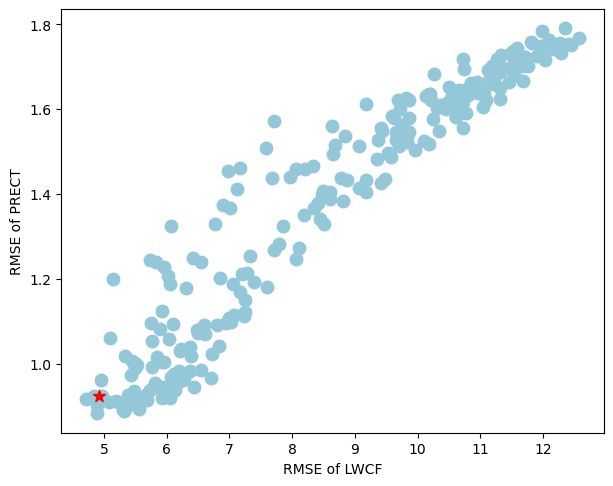

In [25]:
fig,ax = plt.subplots(figsize=(7,5.5))

ax.scatter(met_dataset['LWCF'],met_dataset['PRECT'])
ax.scatter(4.929,0.923,color='r',marker='*')
ax.set_xlabel('RMSE of LWCF')
ax.set_ylabel('RMSE of PRECT')

## skill score 

$E(m)=\log\left[\frac{\left(\sigma_{\mathrm{obs}}/\sigma_{\mathrm{mod}}+\sigma_{\mathrm{mod}}/\sigma_{\mathrm{obs}}\right)^{2}\bigl(1+R_{0}\bigr)^{k}}{4(1+R)^{k}}\right]$

In [7]:
met_dataset = pd.DataFrame()
for i in range(1,251):
    tmp = {}
    diag_path = f'{diag_home}workdir.{i}/{diag_suffix}'
    diag_data = pd.read_csv(diag_path)
    var_names = diag_data['Variables'].values
    sd_obs = diag_data['Ref._STD'].values
    sd_mod = diag_data['Test_STD'].values
    corr = diag_data['Correlation'].values
    tl_scr = np.log((((sd_obs/sd_mod + sd_mod/sd_obs) ** 2) * (2 ** 4))/(4 * (1 + corr) ** 4))
    
    for vn,data in zip(var_names,tl_scr):
        tmp[vn] = data
    tmp = pd.DataFrame(tmp, index=['workdir.'+str(i)])
    met_dataset = pd.concat([met_dataset,tmp])
    
sel_metrics=['PRECT global GPCP_v2.3','SWCF global ceres_ebaf_toa_v4.1',
            'LWCF global ceres_ebaf_toa_v4.1', 'FLUT global ceres_ebaf_toa_v4.1',
            'FSNTOA global ceres_ebaf_toa_v4.1']
sel_name = ['PRECT','SWCF','LWCF','FLUT','FSNTOA']

met_dataset = met_dataset[sel_metrics]
met_dataset.columns = sel_name
met_dataset

metrics = met_dataset.columns

In [8]:
met_dataset

,PRECT,SWCF,LWCF,FLUT,FSNTOA
workdir.1,0.455817,0.372675,0.708319,0.111772,0.021771
workdir.2,0.506212,0.482624,0.832698,0.125508,0.027167
workdir.3,0.524236,0.492425,0.793642,0.122462,0.025359
workdir.4,0.391781,0.354172,0.337344,0.058856,0.019309
workdir.5,0.199753,0.226967,0.209140,0.036770,0.012363
...,...,...,...,...,...
workdir.246,0.231573,0.365011,0.265598,0.055896,0.020207
workdir.247,0.270791,0.208305,0.202940,0.036933,0.012180
workdir.248,0.301660,0.315984,0.226876,0.041220,0.018645
workdir.249,0.432742,0.343657,0.585828,0.092888,0.020312


# metrics from tuning

In [ ]:
seasons = ['ANN','DJF','MAM','JJA','SON']
seasons = ['ANN']
mets = ['LWCF','PRECT','PSL','RELHUM','SWCF','TREFHT','U200','U850','Z500']

cases = ['20210813.F2010.ne30pg2_oECv3.BO.chrysalis',
        '20210813.F2010.ne30pg2_oECv3.chrysalis',
        '20210813.F2010.ne30pg2_oECv3.tune.chrysalis']
diag_home = "/global/homes/z/zhangtao/pwww/"
diag_suffix = "viewer/table-data/ANN_metrics_table.csv"

met_dataset = pd.DataFrame()
for c in cases:
    tmp = {}
    diag_path = f'{diag_home}{c}/{diag_suffix}'
    diag_data = pd.read_csv(diag_path)
    var_names = diag_data['Variables'].values
    dataset = diag_data['RMSE'].values
    for vn,data in zip(var_names,dataset):
        tmp[vn] = data
    tmp = pd.DataFrame(tmp, index=[c])
    met_dataset = pd.concat([met_dataset,tmp])

In [18]:
aa = met_dataset.transpose()
aa.columns = ['BO','CNTL','MAP']
aa.to_csv(f'{diag_home}tune_table.csv')
aa.to_html(f'{diag_home}tune_table.html')

# surrogate

In [8]:
train_x = p_dataset.iloc[:200,:]
train_y = met_dataset.iloc[:200,:]
test_x = p_dataset.iloc[-50:,:]
test_y = met_dataset.iloc[-50:,:]

In [11]:
kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 500000)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-5, 1e1)
)

regs = {'Linear':LinearRegression(),
       'gp':GaussianProcessRegressor(kernel=kernel),
       #'xgb': xgb.XGBRegressor(n_estimators=600, nthread=8, max_depth=7,scale_pos_weight=3.5)
       'xgb': xgb.XGBRegressor(n_estimators=600, nthread=8, max_depth=7) 
       }

PRECT
SWCF
LWCF
FLUT
FSNTOA


/global/cfs/projectdirs/m2136/backup/conda/envs/dushu/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


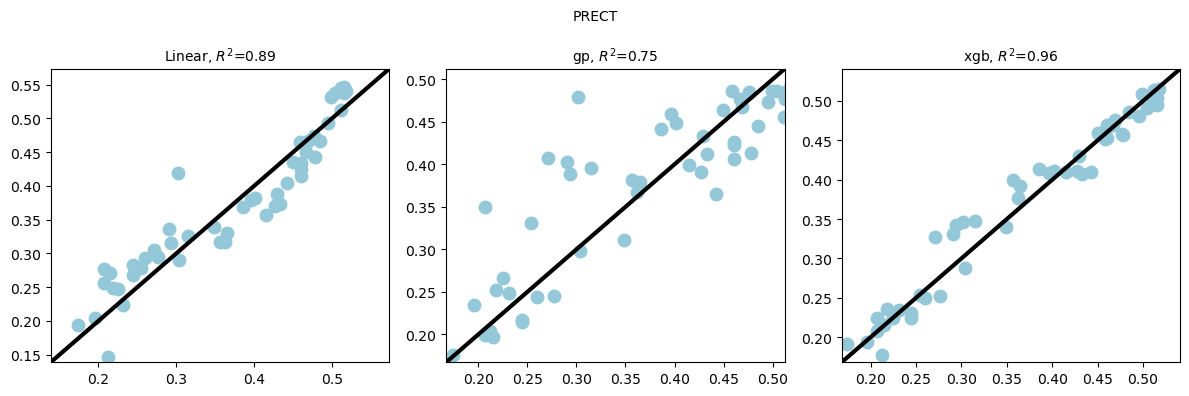

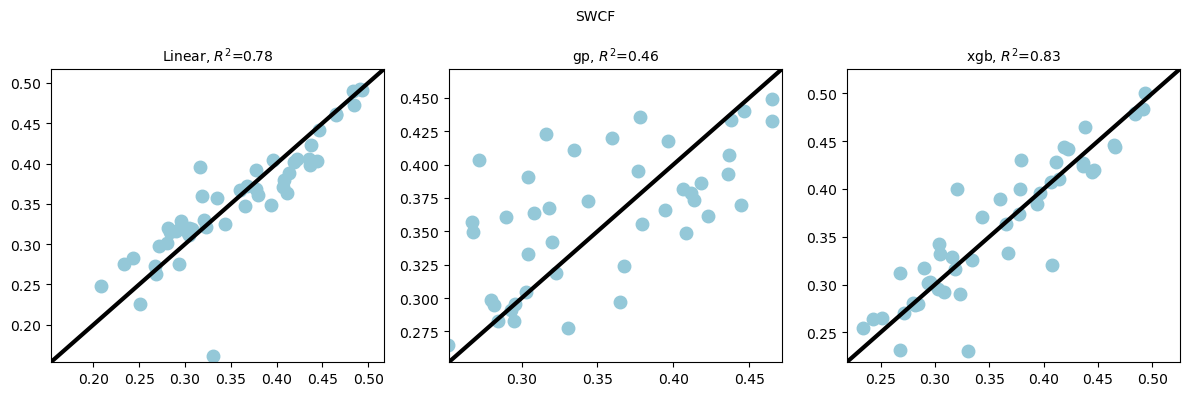

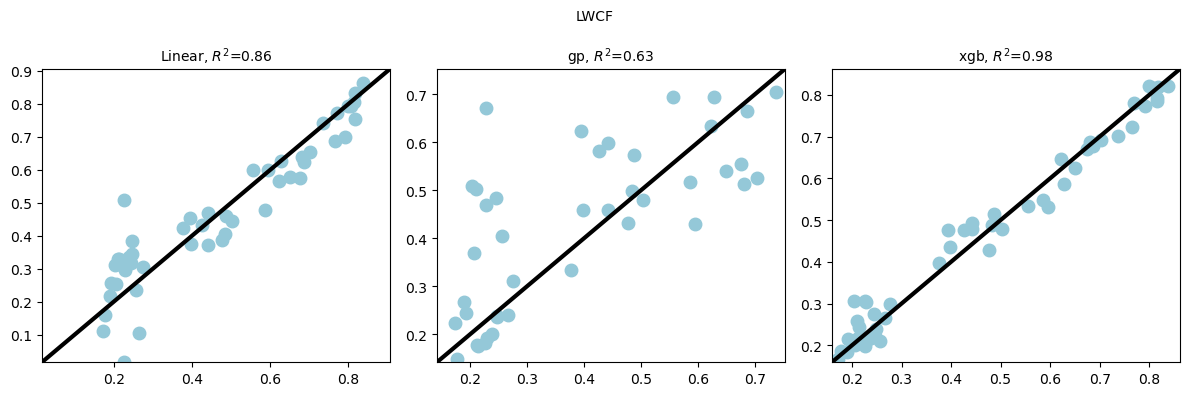

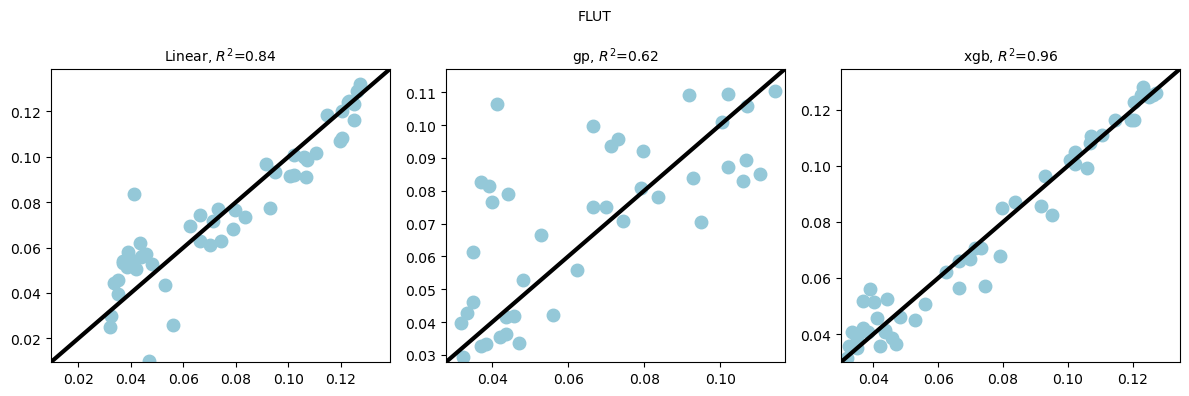

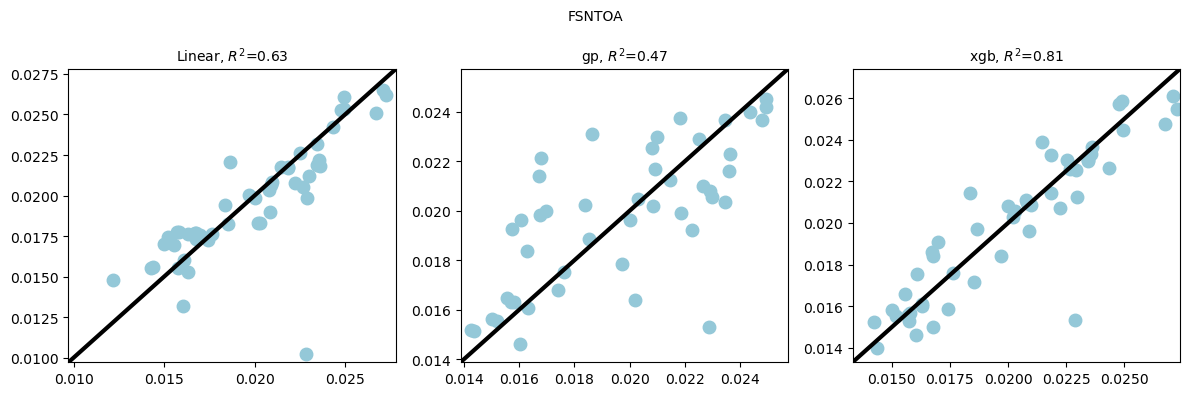

In [12]:
for m in metrics:
    print(m)
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    
    for k,n in enumerate(regs):
        reg = regs[n]
        reg.fit(train_x, train_y.loc[:,m])
        pred = reg.predict(test_x)
        #rmse = mean_squared_error(test_y.loc[:,m], pred, squared=False)
        score = reg.score(test_x,test_y.loc[:,m])
        #print(f'{m}=\t\t\t\t{score:.2f}')
    
        ax[k].scatter(test_y.loc[:,m],pred, label=n)
        ax[k].set_title(f'{n}, $R^2$={score:.2f}')
        ax[k].set_xlim([np.min(pred)*0.95,np.max(pred)*1.05])
        ax[k].set_ylim([np.min(pred)*0.95,np.max(pred)*1.05])
        ax[k].plot([0,1],[0,1], transform=ax[k].transAxes, color='k')
        
    fig.suptitle(m)
    
    plt.tight_layout()

# SA

In [65]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

In [66]:
problem = {
    'num_vars': 5,
    'num_samplings': 250
    'names':['ice_sed_ai', 'clubb_c1', 'clubb_gamma_coef', 
             'zmconv_tau', 'zmconv_dmpdz']
    'bounds':[[1.0, 5.0],
              [0.1,0.5],
              [1800, 14400],
              [-2e-3, -0.1e-3],
              [350,1400]]
}

In [85]:
print(problem)

{'num_vars': 5, 'names': ['ice_sed_ai', 'clubb_c1', 'clubb_gamma_coef', 'zmconv_tau', 'zmconv_dmpdz'], 'bounds': [[1.0, 5.0], [0.1, 0.5], [1800, 14400], [-0.002, -0.0001], [350, 1400]]}


In [70]:
print(metrics.shape)

(30,)


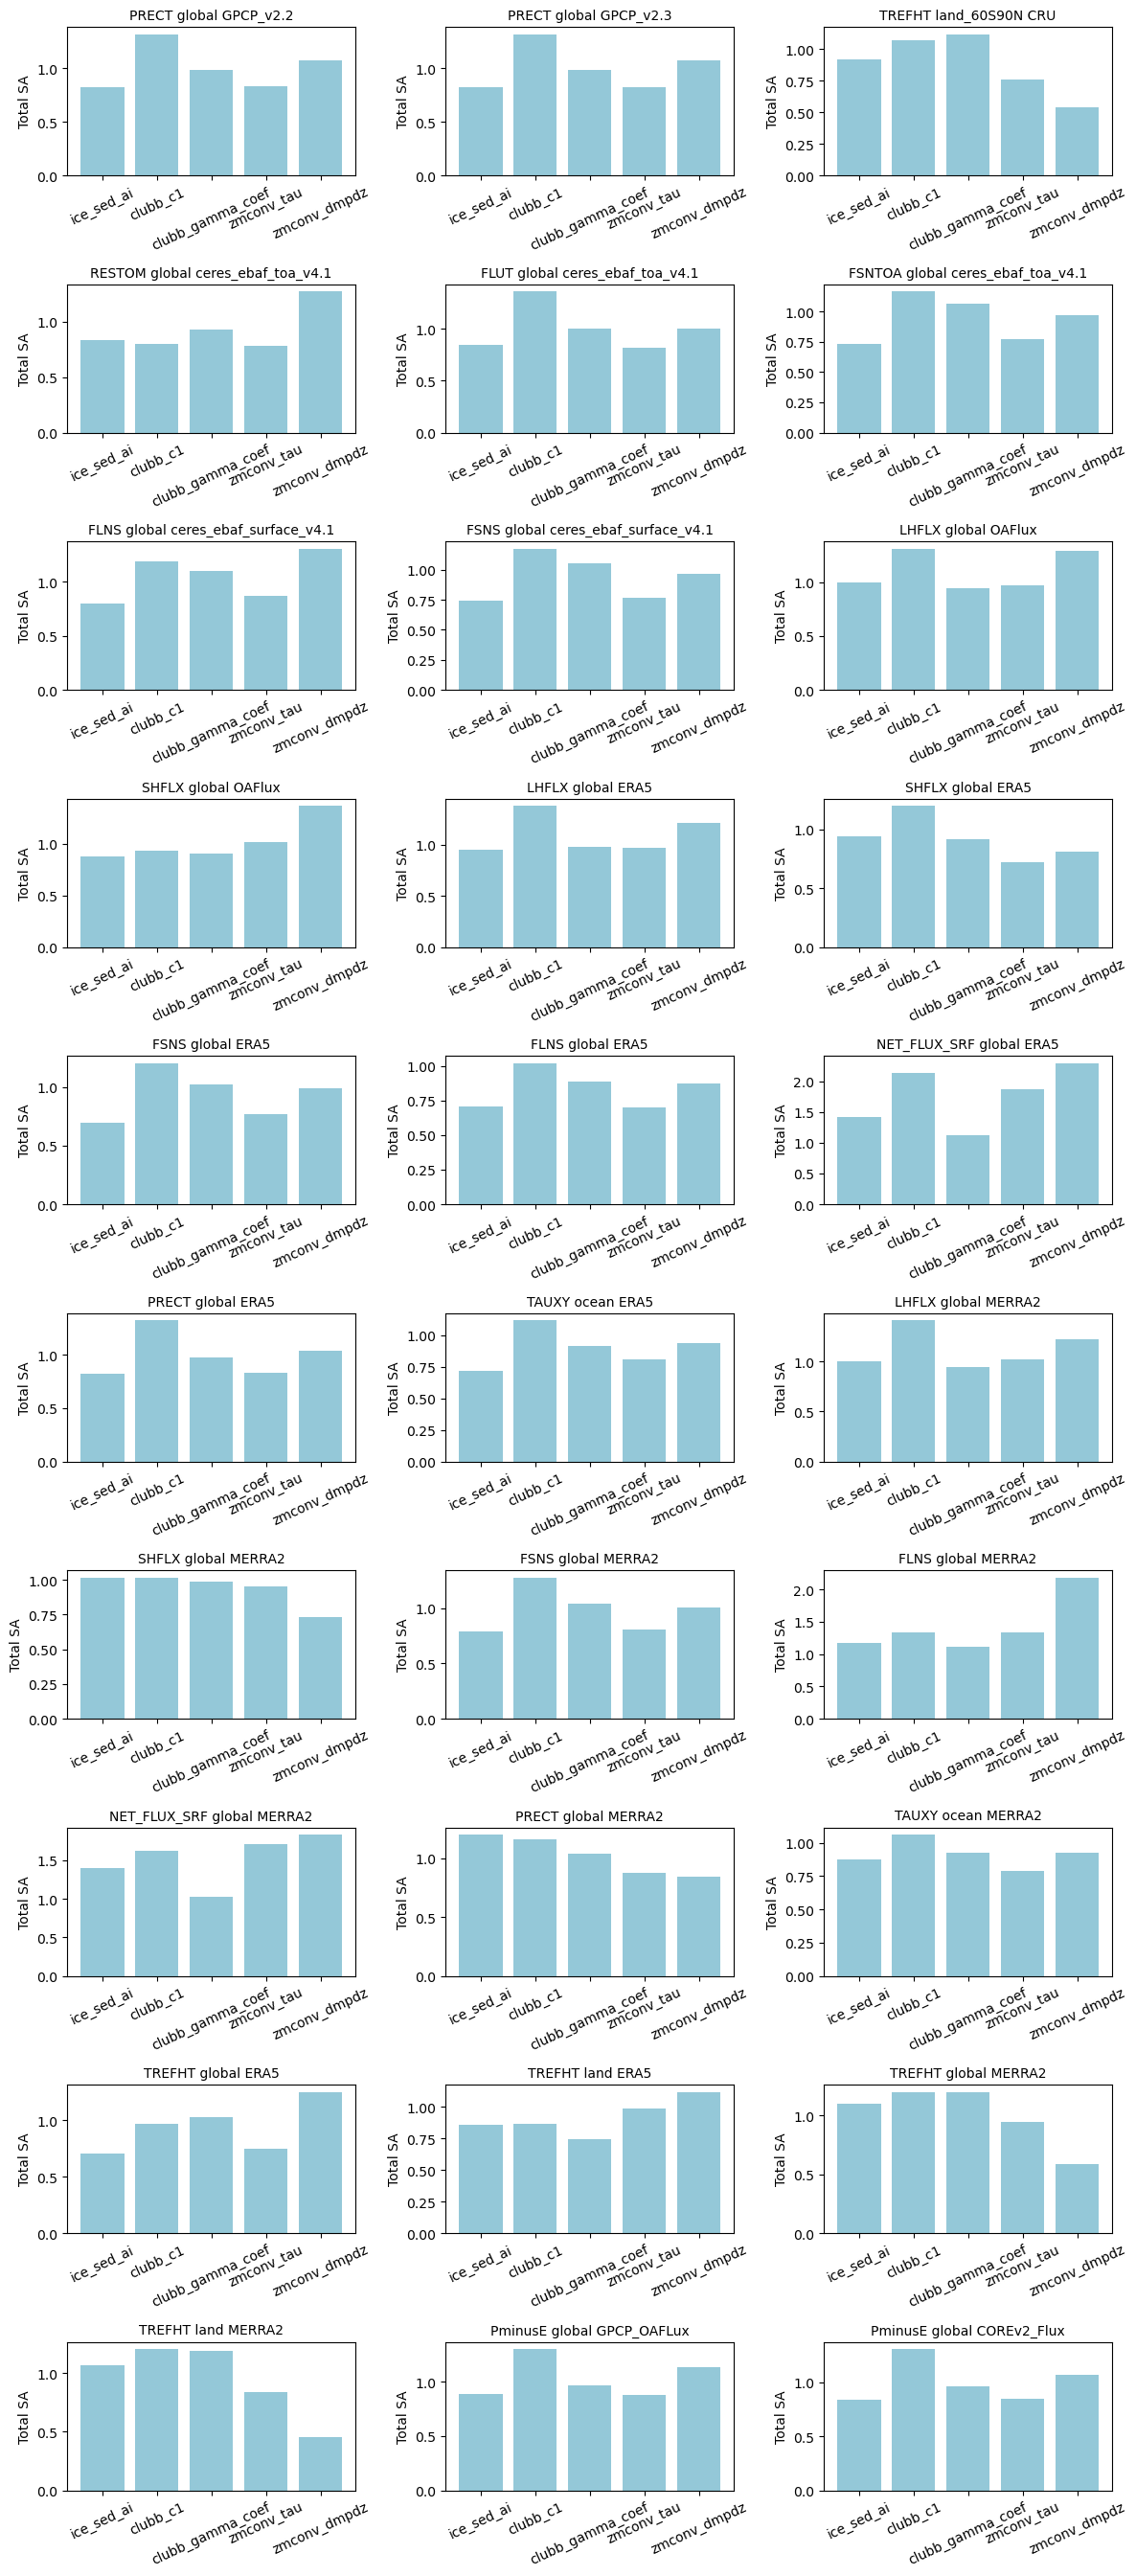

In [84]:
fig,ax = plt.subplots(10,3,figsize=(12,27))

for i,m in enumerate(metrics):
    Y = met_dataset[m].values[:245]
    Si = sobol.analyze(problem,Y,calc_second_order=False)
    ax[i//3][i%3].bar([0,1,2,3,4],Si['ST'])
    ax[i//3][i%3].set_xticks([0,1,2,3,4],p_names,rotation = 25)
    ax[i//3][i%3].set_title(m)
    ax[i//3][i%3].set_ylabel('Total SA')
    
plt.tight_layout()

In [ ]:
#

# gaussian process

In [65]:
#kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(1e-1)
kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 500000)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-5, 1e1)
)
#kernel =  0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
#    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
#)

for m in metrics:
    reg = GaussianProcessRegressor(kernel=kernel)
    reg.fit(train_x, train_y.loc[:,m])
    pred = reg.predict(test_x)
    rmse = mean_squared_error(test_y.loc[:,m], pred, squared=False)
    score = reg.score(test_x,test_y.loc[:,m])
    print(f'{m}=\t\t\t\t{score:.2f}')

PRECT global GPCP_v2.2=				0.79
PRECT global GPCP_v2.3=				0.79
TREFHT land_60S90N CRU=				0.53


/global/cfs/projectdirs/m2136/backup/conda/envs/dushu/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 500000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


RESTOM global ceres_ebaf_toa_v4.1=				-0.01
FLUT global ceres_ebaf_toa_v4.1=				0.61
FSNTOA global ceres_ebaf_toa_v4.1=				0.45
FLNS global ceres_ebaf_surface_v4.1=				0.20
FSNS global ceres_ebaf_surface_v4.1=				0.46
LHFLX global OAFlux=				0.57


/global/cfs/projectdirs/m2136/backup/conda/envs/dushu/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/global/cfs/projectdirs/m2136/backup/conda/envs/dushu/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


SHFLX global OAFlux=				0.79
LHFLX global ERA5=				0.64


/global/cfs/projectdirs/m2136/backup/conda/envs/dushu/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


SHFLX global ERA5=				0.65
FSNS global ERA5=				0.53
FLNS global ERA5=				0.45
NET_FLUX_SRF global ERA5=				-0.01


/global/cfs/projectdirs/m2136/backup/conda/envs/dushu/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 500000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


PRECT global ERA5=				0.76


/global/cfs/projectdirs/m2136/backup/conda/envs/dushu/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


TAUXY ocean ERA5=				0.79
LHFLX global MERRA2=				0.48
SHFLX global MERRA2=				0.47
FSNS global MERRA2=				0.63
FLNS global MERRA2=				-0.04


/global/cfs/projectdirs/m2136/backup/conda/envs/dushu/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 500000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


NET_FLUX_SRF global MERRA2=				0.02
PRECT global MERRA2=				0.36


/global/cfs/projectdirs/m2136/backup/conda/envs/dushu/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


TAUXY ocean MERRA2=				0.60
TREFHT global ERA5=				0.59
TREFHT land ERA5=				-0.04
TREFHT global MERRA2=				0.59
TREFHT land MERRA2=				0.56
PminusE global GPCP_OAFLux=				0.67
PminusE global COREv2_Flux=				0.79


# tuning with surrogate

In [9]:
class metrics:
    def surrogate1(self): #"LWCF" or "PRECT"
        self.reg1 = xgb.XGBRegressor(n_estimators=600, nthread=8, max_depth=7,scale_pos_weight=3.5)
        self.reg2 = xgb.XGBRegressor(n_estimators=600, nthread=8, max_depth=7,scale_pos_weight=3.5)
        
        train_m = train_y.loc[:,'LWCF']
        self.reg1.fit(train_x,train_m)
        train_m = train_y.loc[:,'PRECT']
        self.reg2.fit(train_x,train_m)
        
        self.ref_a = 5.29
        self.ref_b = 0.891
        
    def cost_fun1(self,X):
        return self.reg1.predict(X) 
    
    def cost_fun2(self,X):
        return self.reg2.predict(X)
    
    def cost_fun3(self,X):
        a = self.reg1.predict(X)/self.ref_a
        b = self.reg2.predict(X)/self.ref_b
        return a + b 
    
    def validate(self,X):
        a = self.reg1.predict(X)[0]
        b = self.reg2.predict(X)[0]
        
        print(f'{X}')
        print(f'No normalization LWCF={a:.3f} PRECT={b:.3f}')
        print(f'normalization LWCF={a/self.ref_a:.3f} PRECT={b/self.ref_b:.3f}')

In [10]:
mm = metrics()
mm.surrogate1()

# OAT

In [15]:
from smt.sampling_methods import LHS

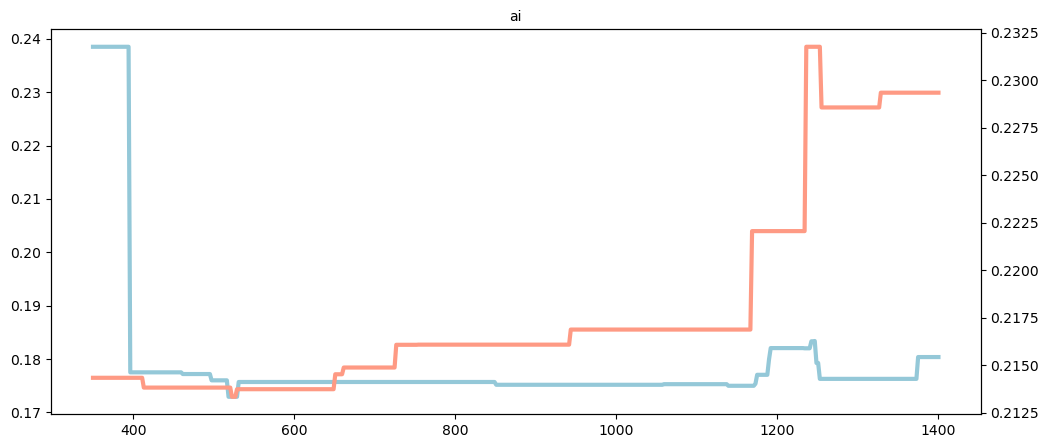

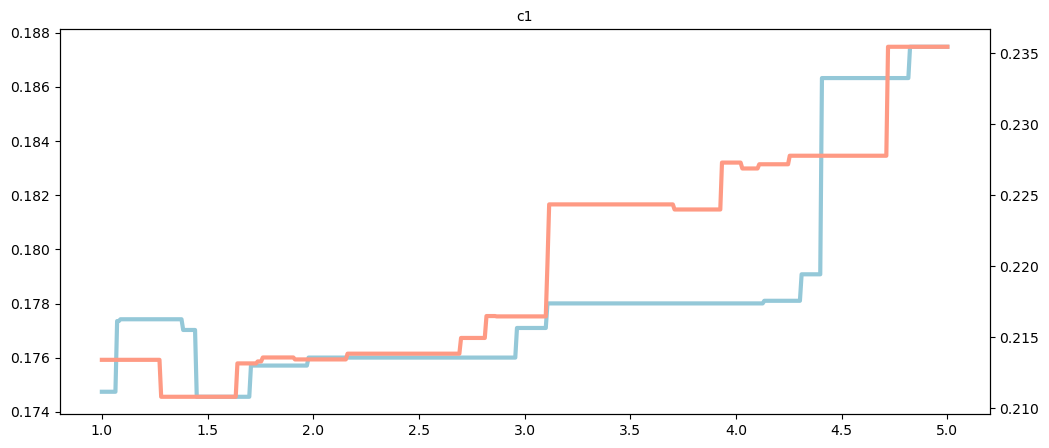

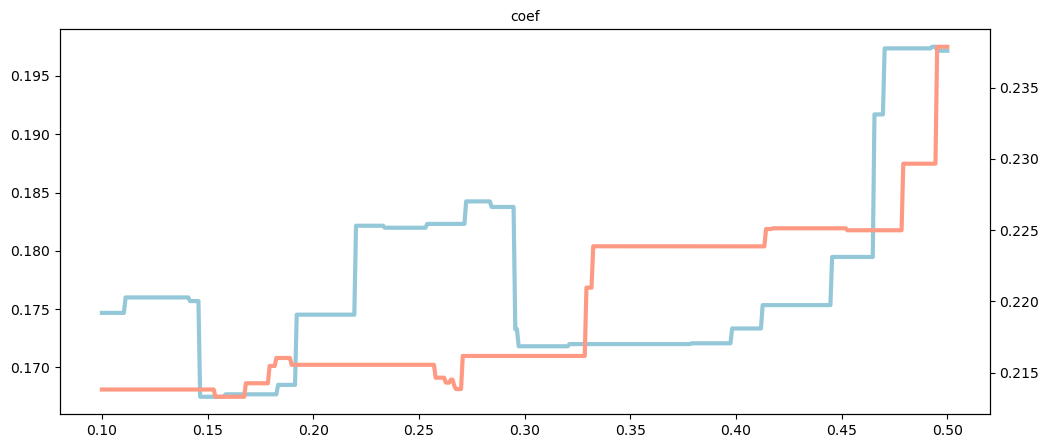

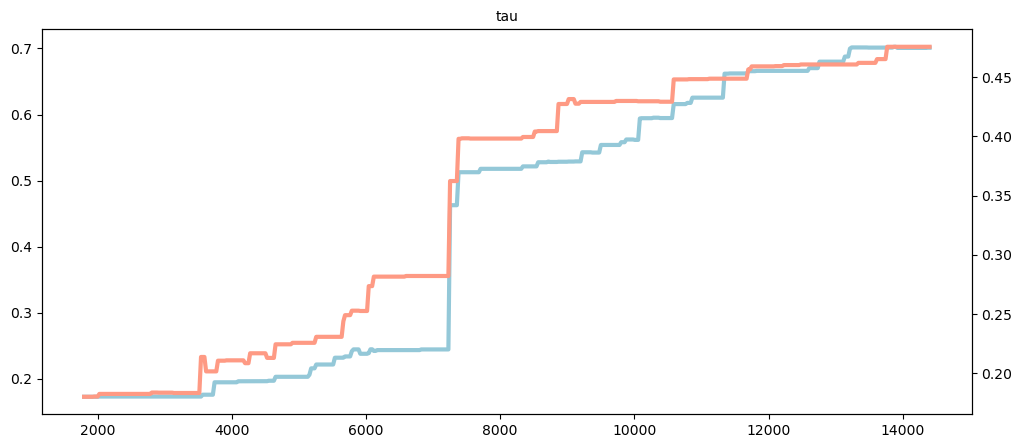

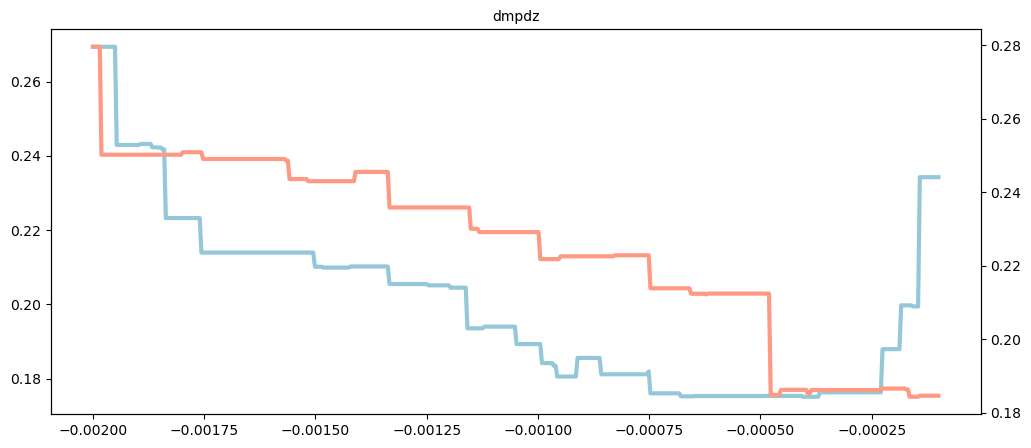

In [58]:
pbounds = {'ai': (350, 1400), 'c1': (1.0, 5.0),
          'coef': (0.1, 0.5), 'tau': (1800, 14400),
          'dmpdz': (-2.0e-3, -0.1e-3)}



defaults = {'ai': 500, 'c1':2.4, 'coef':0.12, 'tau':3600, 'dmpdz':-0.7e-3}

for var in pbounds.keys():
    pb = pbounds[var]
    oat_samps = np.linspace(pb[0],pb[1],500)

    oat_pd = pd.DataFrame()
    oat_pd[var] = oat_samps

    for v in pbounds.keys():
        if v != var:
            oat_pd[v] = defaults[v]


    oat_pd = oat_pd[pbounds.keys()]
    oat_pd.columns = train_x.columns

    pred1 = mm.cost_fun1(oat_pd)
    pred2 = mm.cost_fun2(oat_pd)

    fig,ax = plt.subplots(1,1,figsize=(12,5))
    ax.plot(oat_samps,pred1,label='LWCF')
    
    ax1 = ax.twinx()
    ax1.plot(oat_samps,pred2,label='PRECT',color='#FE9A84')
    
    ax.set_title(var)
  

## BayesianOpt

In [11]:
def fun1(ai, c1, coef, tau, dmpdz):
    X = np.array([ai, c1, coef, tau, dmpdz]).reshape(1,-1)
    pred_y = - (mm.cost_fun1(X))
    return pred_y[0]
    
#fun1(1.3,1.02E20)

In [19]:
pbounds = {'ai': (350, 1400), 'c1': (1.0, 5.0),
          'coef': (0.1, 0.5), 'tau': (1800, 14400),
          'dmpdz': (-2.0e-3, -0.1e-3)}


#default: [500, 1.335, 0.32, 3600, -0.7e-3]

In [20]:
Boptimizer = BayesianOptimization(
    f=fun1,
    pbounds=pbounds,
    random_state=50,
)

Boptimizer.maximize(
    init_points=50,
    n_iter=500,
)

|   iter    |  target   |    ai     |    c1     |   coef    |   dmpdz   |    tau    |
-------------------------------------------------------------------------------------
| 1         | -0.467    | 869.3     | 1.912     | 0.2022    | -0.001247 | 6.554e+03 |
| 2         | -0.2168   | 1.396e+03 | 2.633     | 0.4088    | -0.000555 | 5.706e+03 |
| 3         | -0.3624   | 713.9     | 2.407     | 0.1582    | -0.000151 | 1.326e+04 |
| 4         | -0.2558   | 938.0     | 2.254     | 0.4553    | -0.000718 | 6.728e+03 |
| 5         | -0.6261   | 882.5     | 3.096     | 0.4712    | -0.000914 | 1.022e+04 |
| 6         | -0.8177   | 404.9     | 2.308     | 0.1226    | -0.001658 | 1.347e+04 |
| 7         | -0.795    | 1.335e+03 | 3.856     | 0.3931    | -0.001123 | 1.353e+04 |
| 8         | -0.2135   | 776.7     | 3.733     | 0.36      | -0.000862 | 4.598e+03 |
| 9         | -0.7974   | 1.066e+03 | 4.512     | 0.4187    | -0.001179 | 1.337e+04 |
| 10        | -0.1914   | 1.171e+03 | 3.903     | 0.14

In [40]:
print(Boptimizer.max)
solution = Boptimizer.max['params']
print(solution)

{'target': -0.16094332933425903, 'params': {'ai': 597.6429936286165, 'c1': 2.2205800842879415, 'coef': 0.15190331270805216, 'dmpdz': -0.0005556388677261154, 'tau': 2007.4055355601345}}
{'ai': 597.6429936286165, 'c1': 2.2205800842879415, 'coef': 0.15190331270805216, 'dmpdz': -0.0005556388677261154, 'tau': 2007.4055355601345}


In [15]:
target = np.zeros(500)
curr_best = np.zeros(500)
for i in range(500):
    target[i] = -Boptimizer.res[i]['target']
    
curr_best[0] = target[0]
for i in range(1,500):
    if target[i] < curr_best[i-1]:
        curr_best[i] = target[i]
    else:
        curr_best[i] = curr_best[i-1]

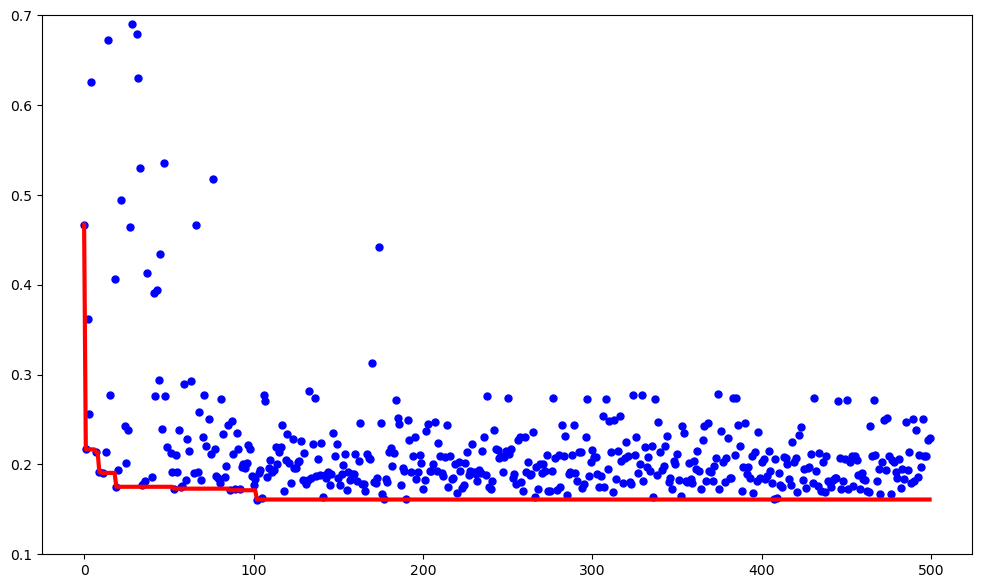

In [44]:
fig = plt.figure(figsize=(12, 7))
plt.plot(target,'b.',ms=10)
plt.ylim([0.1, 0.7])
plt.plot(curr_best,color='r')

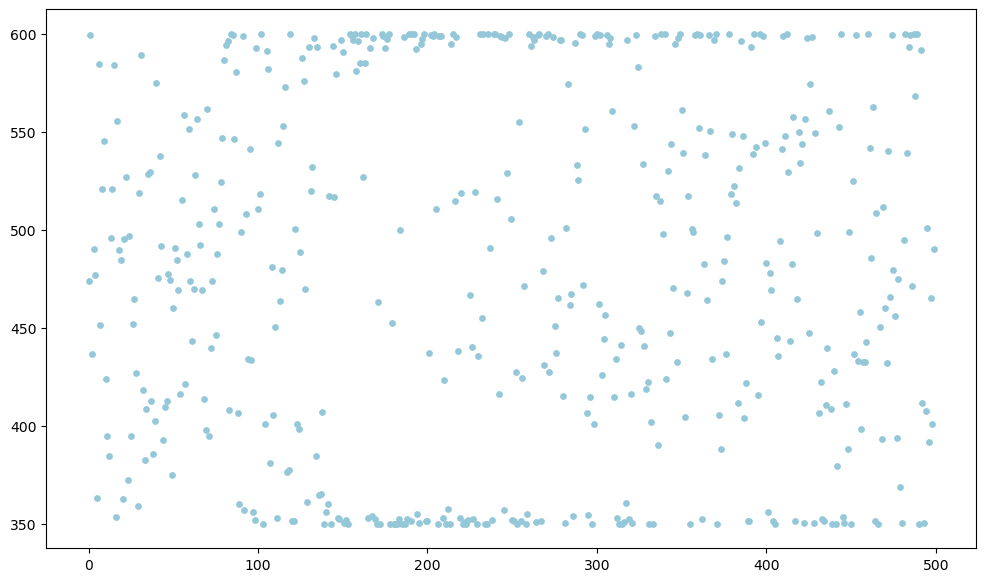

In [18]:
para = np.zeros(500)
for i in range(500):
    para[i] = Boptimizer.res[i]['params']['ai']

fig,ax = plt.subplots(1,1,figsize=(12,7))
ax.scatter(np.arange(len(target)),para,s=15)


In [16]:
ice_sed_ai = 390.818 
clubb_c1 = 1.624
clubb_gamma_coef = 0.179
zmconv_dmpdz = -0.000601
zmconv_tau = 2687.888


#ice_sed_ai =443.223
#clubb_c1 = 1.174
#clubb_gamma_coef = 0.156
#zmconv_tau = 2227.011
#zmconv_dmpdz = -0.000659
 

para = np.array([ice_sed_ai,clubb_c1,clubb_gamma_coef,zmconv_tau,zmconv_dmpdz]).reshape(1,-1)

mm.validate(para)

[[ 3.908180e+02  1.624000e+00  1.790000e-01  2.687888e+03 -6.010000e-04]]
No normalization LWCF=4.602 PRECT=0.886
normalization LWCF=0.870 PRECT=0.994


In [120]:
print(Boptimizer.res[328])

{'target': -1.9404135942459106, 'params': {'ai': 480.0067262455701, 'c1': 2.027190984304075, 'coef': 0.11965934099507734, 'dmpdz': -0.0004934991326674071, 'tau': 2641.601527876257}}


In [23]:
data = np.zeros((1,5))
for i,v in enumerate(solution):
    data[0,i] = solution[v]
    
data = np.array([506.7,3.744,0.1292,-0.000254,2.313e+03]).reshape(1,-1)
#data = np.array([1360.25,1.13,0.265,-0.00049,4049.74]).reshape(1,-1)
data = np.array([500,1.335,0.32,-0.7e-3, 3600]).reshape(1,-1)
pred_y = reg.predict(data)
print(pred_y)

[5.293064]


## nelder mead

In [43]:
def fun2(X):
    X = X.reshape(1,-1)
    pred_y = reg.predict(X) + reg1.predict(X)
    return pred_y

In [44]:
x0 = np.array([500, 1.335, 0.32, 3600, -0.7e-3])
x0 = np.array([686.4, 3.904, 0.1895, 2.152e+03,-0.000366])

res = minimize(fun2, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True, 'return_all':True})

Optimization terminated successfully.
         Current function value: 1.950389
         Iterations: 55
         Function evaluations: 273


In [42]:
print(res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5.946317195892334
             x: [ 6.950e+02  4.135e+00  1.831e-01  2.151e+03 -3.724e-04]
           nit: 50
          nfev: 255
 final_simplex: (array([[ 6.950e+02,  4.135e+00, ...,  2.151e+03,
                        -3.724e-04],
                       [ 6.950e+02,  4.135e+00, ...,  2.151e+03,
                        -3.724e-04],
                       ...,
                       [ 6.950e+02,  4.135e+00, ...,  2.151e+03,
                        -3.724e-04],
                       [ 6.950e+02,  4.135e+00, ...,  2.151e+03,
                        -3.724e-04]]), array([ 5.946e+00,  5.946e+00,  5.946e+00,  5.946e+00,
                        5.946e+00,  5.946e+00]))
       allvecs: [array([ 6.864e+02,  3.904e+00,  1.895e-01,  2.152e+03,
                       -3.660e-04]), array([ 7.001e+02,  3.982e+00,  1.800e-01,  2.195e+03,
                       -3.733e-04]), array([ 7.001e+02

In [74]:
data = np.array([ 6.864e+02,4.099e+00,1.895e-01,2.152e+03,-3.660e-04]).reshape(1,-1)
pred_y = reg.predict(data)
print(pred_y)

[0.9015588]


## Multi-objective tuning

In [209]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

In [210]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=5,
                         n_obj=2,
                         #n_ieq_constr=2,
                         xl=np.array([350,1.0,0.1,1800,-2.0e-3]),
                         xu=np.array([1400,5.0,0.5,14400,-0.1e-3]))

    def _evaluate(self, x, out, *args, **kwargs):
        x = x.reshape(1,-1)
        f1 = mm.reg1.predict(x)
        f2 = mm.reg2.predict(x)

        out["F"] = [f1, f2]


xl = np.array([350,1.0,0.1,1800,-2.0e-3])
xu = np.array([1400,5.0,0.5,14400,-0.1e-3])
problem = MyProblem()

In [211]:


algorithm = NSGA2(pop_size=100)
res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      5 |             - |             -
     2 |      200 |      4 |  0.3187473267 |         ideal
     3 |      300 |      2 |  2.8699617155 |         ideal
     4 |      400 |      4 |  0.1998069552 |         ideal
     5 |      500 |      6 |  0.0750145969 |         ideal
     6 |      600 |      7 |  0.0875118523 |         ideal
     7 |      700 |      9 |  0.1343423066 |         ideal
     8 |      800 |     10 |  0.0349262088 |             f
     9 |      900 |     11 |  0.0735192780 |         ideal
    10 |     1000 |     15 |  0.0329840218 |         ideal
    11 |     1100 |     17 |  0.0892172335 |         ideal
    12 |     1200 |     19 |  0.1366592621 |         nadir
    13 |     1300 |     15 |  0.0030939456 |         ideal
    14 |     1400 |     15 |  0.0127960250 |         ideal
    15 |     1500 |     16 |  0.0529762535 |         ideal
    16 |     1600 |     19 |  0.0094622711 |            

In [212]:
X = res.X
F = res.F

Text(0, 0.5, 'RMSE of LWCF')

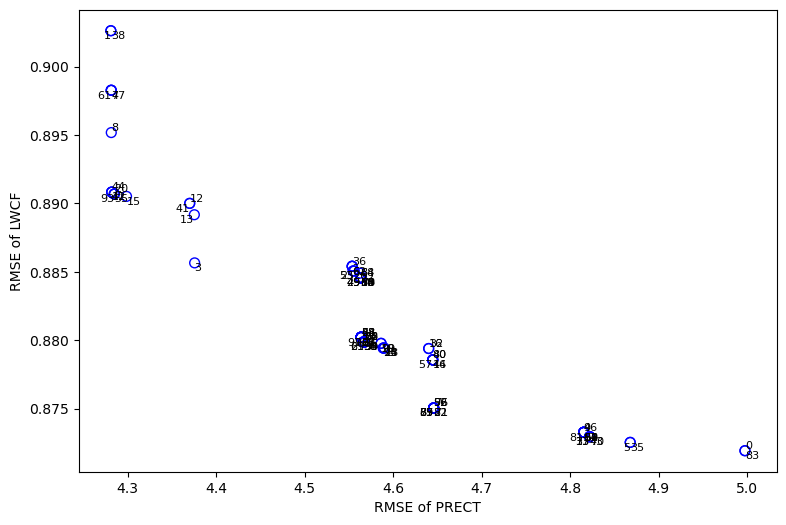

In [230]:
fig,axes = plt.subplots(1,1,figsize=(9,6))

for index in np.arange(F.shape[0]):
    if index%4 == 0:
        va = 'bottom'
        ha = 'left'
    elif index%4 == 1:
        va = 'top'
        ha = 'right'
    elif index%4 == 2:
        va = 'top'
        ha = 'left'
    axes.text(F[index,0],F[index,1],index,fontsize=8,va=va,ha=ha)

axes.scatter(F[:, 0], F[:, 1], s=50, facecolors='none', edgecolors='blue')
axes.set_xlabel('RMSE of PRECT')
axes.set_ylabel('RMSE of LWCF')

In [234]:
#print(F)
np.set_printoptions(suppress=True)
print(X)

[[ 582.56927525    2.9514445     0.18536478 1965.97684016   -0.00060748]
 [ 443.22344366    1.17383528    0.15597974 2227.01120773   -0.00065787]
 [ 493.91612301    2.9153425     0.17954714 2128.30367682   -0.00060542]
 [ 508.97630969    1.16992653    0.18028409 2129.52062565   -0.00065764]
 [ 493.75764669    3.76218657    0.18203139 2125.43358038   -0.00060542]
 [ 581.56838154    2.16575172    0.1803563  1967.1428796    -0.00058714]
 [ 443.96240191    2.94800248    0.17957432 2118.01187971   -0.0004032 ]
 [ 443.97177476    1.17383535    0.18084642 2227.01120773   -0.00065787]
 [ 443.44380505    1.17383387    0.15612625 1968.16127806   -0.00065787]
 [ 444.21681216    2.94168492    0.17991859 2026.21144785   -0.00058424]
 [ 443.22751661    2.9531787     0.14521766 2008.86425594   -0.00058792]
 [ 443.44380505    1.17383387    0.17955839 2127.54569008   -0.00065787]
 [ 508.97630969    1.16992653    0.15666595 2129.52062565   -0.00065764]
 [ 462.98480498    1.10782051    0.17666936 2030.73

In [58]:
### ai     |    c1     |   coef    |   dmpdz   |    tau    |

In [26]:
[ice_sed_ai,clubb_c1,clubb_gamma_coef,zmconv_tau,zmconv_dmpdz]

[390.818, 1.624, 0.179, 2687.888, -0.000601]

In [57]:
train_x_extra = np.array([[390.818, 1.624, 0.179, 2687.888, -0.000601]
])
train_y_extra = np.array([[4.737,0.92],
                          [5.149,0.918],
                          [4.885,0.915],
                          [4.703,0.947]
])
prect_y_extra = np.array([[4.602,0.886],
                          [4.80,0.90],
                          [4.640,0.895],
                          [4.702,0.887]
])

In [58]:
train_y

,PRECT,SWCF,LWCF,FLUT,FSNTOA
workdir.1,1.646,14.072,10.549,11.766,13.770
workdir.2,1.740,17.915,12.247,13.726,17.554
workdir.3,1.756,18.222,11.825,13.269,17.986
workdir.4,1.458,14.202,8.064,8.114,13.848
workdir.5,0.957,9.648,6.187,6.023,9.200
...,...,...,...,...,...
workdir.196,1.741,17.671,11.971,13.458,17.332
workdir.197,1.034,9.732,6.230,5.949,9.221
workdir.198,1.701,16.847,11.188,12.454,16.546
workdir.199,0.945,10.036,5.808,5.922,9.576


In [53]:
train_y_extra[:,0]

array([4.737, 5.149])

LWCF
PRECT


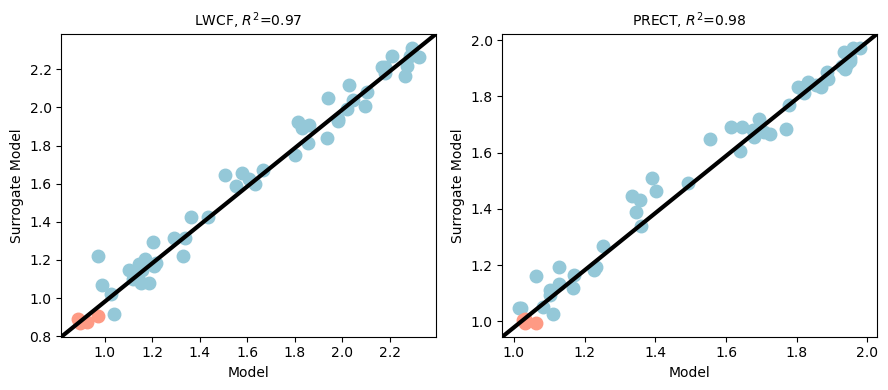

In [69]:
reg = xgb.XGBRegressor(n_estimators=600, nthread=8, max_depth=7) 
fig, ax = plt.subplots(1,2,figsize=(9,4))

ref = [5.29,0.891]

for k,m in enumerate(['LWCF','PRECT']):
    print(m)
    reg.fit(train_x, train_y.loc[:,m])
    pred = reg.predict(test_x)
    #rmse = mean_squared_error(test_y.loc[:,m], pred, squared=False)
    score = reg.score(test_x,test_y.loc[:,m])
    #print(f'{m}=\t\t\t\t{score:.2f}')

    ax[k].scatter(test_y.loc[:,m]/ref[k],pred/ref[k])
    ax[k].set_title(f'{m}, $R^2$={score:.2f}')
    #ax[k].set_xlim([np.min(pred)*0.90,np.max(pred)*1.05])
    #ax[k].set_ylim([np.min(pred)*0.90,np.max(pred)*1.05])
    ax[k].plot([0,1],[0,1], transform=ax[k].transAxes, color='k')
    ax[k].set_xlabel('Model')
    ax[k].set_ylabel('Surrogate Model')
    

    
    ax[k].scatter(train_y_extra[:,k]/ref[k],prect_y_extra[:,k]/ref[k],color='#FE9A84')
    
    #ax[0].scatter(4.929,5.29,marker='*',color='r')
    #ax[1].scatter(0.923,0.891,marker='*',color='r')
      
plt.tight_layout()